In [3]:
import torch
import torchvision.models as models
import torch.nn as nn
from torchsummary import summary

import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from sklearn.model_selection import train_test_split
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

data_path = "C:/Users/arwin/Documents/dev/APS360-PROJECT/data"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


The Genre Classification Model Class:

In [4]:

class BigModel(nn.Module):
  def  __init__(self):
    super(BigModel, self).__init__()
    # CNN
    resnet18 = models.resnet18(pretrained=True)
    self.features = nn.Sequential(*(list(resnet18.children())[:-2])) # I removed the last two layers of resnet and replaced them with the ones said in the paper
    self.features.add_module("pool", nn.AdaptiveMaxPool2d((1,1)))

    self.fc1_cnn = nn.Linear(512, 256)
    self.dropout_cnn = nn.Dropout(p = 0.5)
    self.batch_norm_cnn = nn.BatchNorm1d(256)
    
    # RNN
    self.bi_gru = nn.GRU(input_size=672, hidden_size = 256, num_layers =1, batch_first=True, bidirectional=True) # I dont know what the size of the input to the bi-gru is supposed to be
    self.fc_gru = nn.Linear(512, 256)
    
    # FC LAYERS
    self.dropout = nn.Dropout(p = 0.5)
    # self.fc = nn.Linear(512, 1)
    self.fc = nn.Linear(512, 10) # becuase 10 genre classes
    # self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    # CNN
    # print(f"Shape before ResNet features: {x.shape}")  # Debug statement 1
    x1 = self.features(x)
    # print(f"Shape after ResNet features: {x1.shape}")  # Debug statement 1
    x1 = torch.flatten(x1, 1)
    # print(f"Shape after flattening: {x1.shape}")  # Debug statement 2
    x1 = self.fc1_cnn(x1)
    x1 = self.dropout_cnn(x1)
    x1 = self.batch_norm_cnn(x1)
    
    # Bi-GRU
    batch_size, channels, height, width = x.shape
    x2 = x.view(batch_size, height, -1)
    # print(f"Shape before Bi-GRU: {x2.shape}")  # Debug statement 4
    x2, _ = self.bi_gru(x2)
    x2 = torch.cat((x2[:, -1, :256], x2[:, 0, 256:]), dim=1)
    x2 = self.fc_gru(x2)

    # Concat Outputs of each model
    x = torch.cat((x1, x2), -1)
    x = self.dropout(x)
    x = self.fc(x)
    # x = self.sigmoid(x)
    return x

Helper Function

In [5]:
def get_model_name(batch_size, learning_rate, epoch, weight_decay):
    """ Generate a name for the model consisting of all the hyperparameter values

    Args:
        config: Configuration object containing the hyperparameters
    Returns:
        path: A string with the hyperparameter name and value concatenated
    """
    path = "transfermodel_bs{0}_lr{1}_epoch{2}_wd{3}".format(
                                                   batch_size,
                                                   learning_rate,
                                                   epoch,
                                                   weight_decay)
    return path

Function to Modify The Pretrained Model by freezing CNN, Bi-Gru Layers and modifying fc layers for Binary Classification

In [6]:
def modify_model_for_binary_classification(model):
    # Freeze feature layers
    for param in model.features.parameters():
        param.requires_grad = False
    for param in model.bi_gru.parameters():
        param.requires_grad = False
    # for param in model.fc1_cnn.parameters():
    #     param.requires_grad = False
    # for param in model.fc_gru.parameters():
    #     param.requires_grad = False
    # for param in model.batch_norm_cnn.parameters():
    #     param.requires_grad = False
    
    # Remove and add new FC layers for binary classification
    # Adjust the input features of the first linear layer according to your new architecture
    model.fc = nn.Sequential(
        nn.Linear(512, 256),  # Adjust the input size if needed
        nn.ReLU(),
        nn.Dropout(p=0.5),
        nn.Linear(256, 1),
        nn.Sigmoid()
    )

    return model

Image Dataset Class that has 2 classes or Binary Classification

In [7]:
class CustomImageDataset(Dataset):
    def __init__(self, img_dirs, transform=None):
        """
        Args:
            img_dirs (dict): Dictionary with keys 'hit' and 'miss' and their respective image directory paths.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.img_labels = []
        self.img_files = []
        for label, dir_path in img_dirs.items():
            for file in os.listdir(dir_path):
                if file.endswith('.png'):
                    self.img_files.append(os.path.join(dir_path, file))
                    self.img_labels.append(1 if label=='hit' else 0)
        self.transform = transform

    def __len__(self):
        return len(self.img_files)

    def __getitem__(self, idx):
        img_path = self.img_files[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.float) 


In [8]:
transform = transforms.Compose([
    # transforms.Resize((224, 224)),  
    transforms.ToTensor(),
])
img_dirs = {
    'hit': data_path + '/billboard_spec',
    'miss': data_path + '/random_spec'
}

# Initialize your dataset
dataset = CustomImageDataset(img_dirs=img_dirs, transform=transform)


Create Splits

In [9]:
train_size = int(0.7 * len(dataset))
val_size = int(0.15 * len(dataset))
test_size = len(dataset) - train_size - val_size

train_dataset, val_test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size + test_size])
val_dataset, test_dataset = torch.utils.data.random_split(val_test_dataset, [val_size, test_size])


Train

In [10]:
def train(model, batch_size, learning_rate, num_epochs, weight_decay, save=True):
    
    # data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    # Setup train
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

    # Lists to keep track of progress
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    # Accuracy calculation function
    def binary_accuracy(preds, y):
        rounded_preds = torch.round(preds)
        correct = (rounded_preds == y).float()
        acc = correct.sum() / len(correct)
        return acc

    # Training loop
    num_epochs = num_epochs

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        running_corrects = 0
        
        # Training
        iteration = 1
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # Adjust for label dimensions

            # print("input shape: ", inputs.shape, " labels shape: ", labels.shape)
            optimizer.zero_grad()

            outputs = model(inputs)
            # print("outputs shape: ", outputs.shape)
            loss = criterion(outputs, labels)
            acc = binary_accuracy(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += acc.item() * inputs.size(0)

            # print(f"Iteration {iteration} complete.")
            iteration += 1 
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = running_corrects / len(train_loader.dataset)

        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        # print("validating...")
        # Validation
        model.eval()
        val_running_loss = 0.0
        val_running_corrects = 0
        
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device).float().unsqueeze(1)  # Adjust for label dimensions

                outputs = model(inputs)
                loss = criterion(outputs, labels)
                acc = binary_accuracy(outputs, labels)

                val_running_loss += loss.item() * inputs.size(0)
                val_running_corrects += acc.item() * inputs.size(0)
        
        val_loss = val_running_loss / len(val_loader.dataset)
        val_acc = val_running_corrects / len(val_loader.dataset)

        val_losses.append(val_loss)
        val_accuracies.append(val_acc)

        print(f'Epoch {epoch+1}, Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')
    
    # Optional: Save model and training history
    if save:
        model_name = get_model_name(batch_size=batch_size, learning_rate=learning_rate, epoch=num_epochs, weight_decay=weight_decay)
        dir = f'{model_name}/'
        if not os.path.exists(dir):
            os.makedirs(dir)
        torch.save(model.state_dict(), f'{model_name}/{model_name}.pth')
        np.savez(f'{model_name}/{model_name}.npz', train_losses=train_losses, train_accuracies=train_accuracies, val_losses=val_losses, val_accuracies=val_accuracies)


In [11]:
def plot_model(model_name):
    # Load the saved training history

    data = np.load(f'{model_name}/{model_name}.npz')

    # Extracting the training and validation losses and accuracies
    train_losses = data['train_losses']
    val_losses = data['val_losses']
    train_accuracies = data['train_accuracies']
    val_accuracies = data['val_accuracies']

    # Plotting
    fig, axs = plt.subplots(2, 1, figsize=(10, 10))

    # Plot training and validation losses

    # Example for setting text size individually
    axs[0].set_xlabel('Epochs', fontsize=20)  # Adjust fontsize as needed
    axs[0].set_ylabel('Loss', fontsize=20)  # Adjust fontsize as needed
    axs[0].set_title(f'Training and Validation Loss for {model_name}', fontsize=16)  # Adjust fontsize as needed
    axs[0].legend(fontsize=20)
    axs[0].set_xlim(0, len(train_losses))  # Set x-axis range from 0 to number of epochs
    # axs[0].set_ylim(0, max(max(train_losses), max(val_losses)))  # Set y-axis range

    # And similarly for other text elements

    axs[0].plot(train_losses, label='Training Loss')
    axs[0].plot(val_losses, label='Validation Loss')



    # Plot training and validation accuracies
    axs[1].plot(train_accuracies, label='Training Accuracy')
    axs[1].plot(val_accuracies, label='Validation Accuracy')
    axs[1].set_xlabel('Epochs', fontsize=20)
    axs[1].set_ylabel('Accuracy', fontsize=20)
    axs[1].set_title(f'Training and Validation Accuracy for {model_name}',fontsize=16)
    axs[1].legend()
    axs[1].set_xlim(0, len(train_accuracies))  # Set x-axis range from 0 to number of epochs
    # axs[1].set_ylim(0, 1)  # Assuming accuracy ranges from 0 to 1

    plt.tight_layout()
    plt.show()

# Train the Model
Also Load pretrained weights and call modify function \
Set hyperparams


c:\Users\arwin\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\arwin\anaconda3\envs\torch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1, Train Loss: 0.6427, Train Acc: 0.6231, Val Loss: 0.5972, Val Acc: 0.6967
Epoch 2, Train Loss: 0.6210, Train Acc: 0.6619, Val Loss: 0.5845, Val Acc: 0.7013
Epoch 3, Train Loss: 0.6089, Train Acc: 0.6752, Val Loss: 0.5790, Val Acc: 0.7093
Epoch 4, Train Loss: 0.6039, Train Acc: 0.6765, Val Loss: 0.5809, Val Acc: 0.7013
Epoch 5, Train Loss: 0.5879, Train Acc: 0.6824, Val Loss: 0.5694, Val Acc: 0.7070
Epoch 6, Train Loss: 0.5777, Train Acc: 0.6975, Val Loss: 0.5556, Val Acc: 0.7174
Epoch 7, Train Loss: 0.5788, Train Acc: 0.6942, Val Loss: 0.5472, Val Acc: 0.7428
Epoch 8, Train Loss: 0.5704, Train Acc: 0.6994, Val Loss: 0.5527, Val Acc: 0.7186
Epoch 9, Train Loss: 0.5693, Train Acc: 0.7063, Val Loss: 0.5501, Val Acc: 0.7232
Epoch 10, Train Loss: 0.5576, Train Acc: 0.7167, Val Loss: 0.5258, Val Acc: 0.7532
Epoch 11, Train Loss: 0.5509, Train Acc: 0.7165, Val Loss: 0.5202, Val Acc: 0.7474
Epoch 12, Train Loss: 0.5545, Train Acc: 0.7162, Val Loss: 0.5249, Val Acc: 0.7532
Epoch 13, Tra

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


Epoch 75, Train Loss: 0.4577, Train Acc: 0.7787, Val Loss: 0.4874, Val Acc: 0.7762


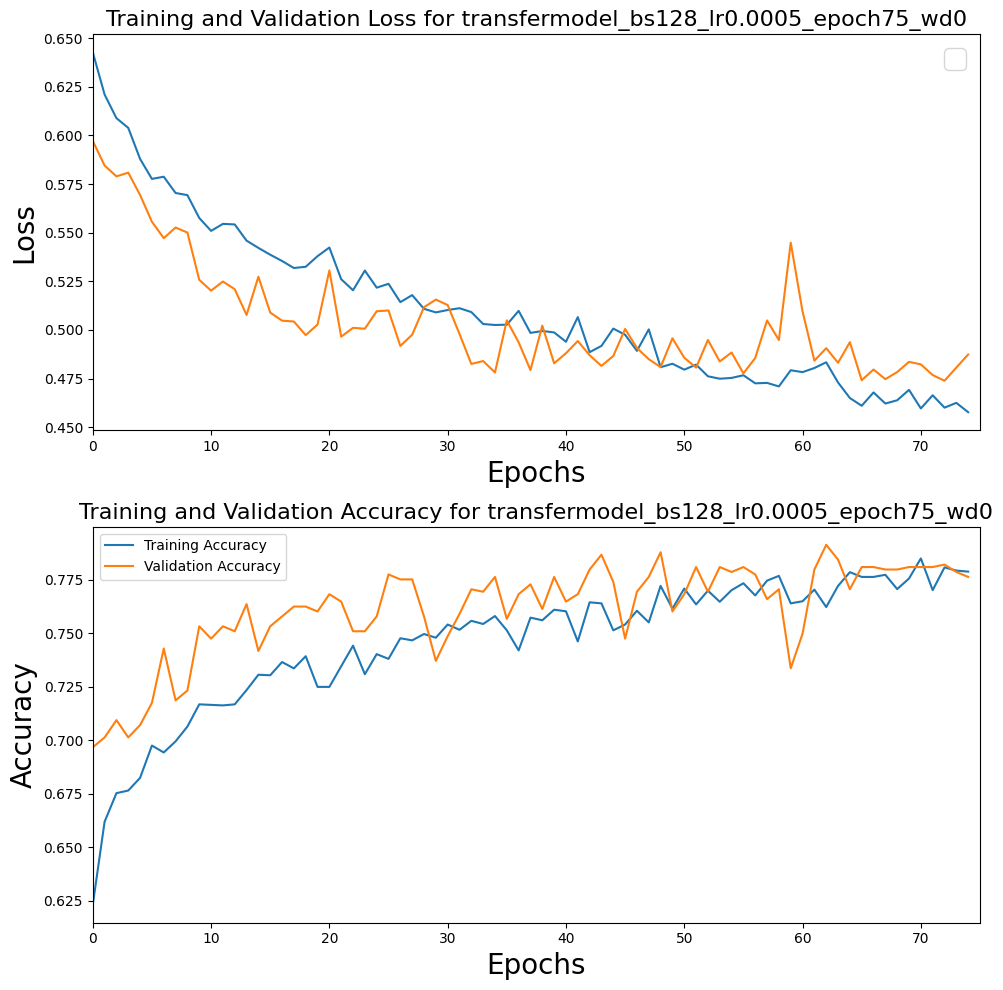

In [12]:
model = BigModel()
path_to_saved_model = 'C:/Users/arwin/Documents/dev/APS360-PROJECT/genre_classifier/genre_ensemble_model_batch256_lr0.001_weightdecay3e-05.pth' 
model.load_state_dict(torch.load(path_to_saved_model))
model = modify_model_for_binary_classification(model)
model = model.to(device)
# summary(model, input_size=(3, 224, 224))

batch_size = 128
learning_rate = 0.0005
num_epochs = 75
weight_decay = 0
save = True

train(model, batch_size=batch_size, learning_rate=learning_rate, num_epochs=num_epochs, weight_decay=weight_decay, save=save)
model_name=get_model_name(batch_size=batch_size, learning_rate=learning_rate, epoch=num_epochs, weight_decay=weight_decay)
plot_model(model_name)

Test Model

In [ ]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
